### Stockmarket simulation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import string
import sys
import time
import scipy.stats as stats
from enum import Enum
from itertools import combinations

In [2]:
class Order(Enum):
    BUY = 1
    SELL = 2
    HOLD = 3

class Trader():
    def __init__(self, ind, cash, num_stocks, tendency):
        self.ind = ind
        self.cash = cash
        self.num_stocks = num_stocks
        self.tendency = tendency
        self.cluster = None
        self.order = None
        self.price = None
        self.num_stocks_trade = None
        self.cluster_action = False
        self.create_rnd_cluster()
    
    def create_rnd_cluster(self, l_=5):
        pool = string.ascii_letters + string.digits
        self.cluster = ''.join(random.choice(pool) for i in range(l_))
    
    def buy_sell_hold(self):
        ind = np.random.rand()
        if self.cluster_action:
            return
        else:
            if ind < 1/3:
                self.order = Order(1)
            elif ind < 2/3:
                self.order = Order(2)
            else:
                self.order = Order(3)

    def maintain_order(self, price, expected_percentage=5):
        price_change = 0.01 * random.expovariate(1/expected_percentage) * price
        if self.order == Order.BUY:
            self.price = price * 1.05 - price_change
        if self.order == Order.SELL:
            self.price = price * 0.95 + price_change

    def amount(self, price):
        if self.cluster_action: ###
            return ###
        else: ###
            if self.order == Order.BUY:
                self.num_stocks_trade = np.round(random.uniform(0, 0.9 * self.cash) / price)
            if self.order == Order.SELL:
                self.num_stocks_trade = random.randint(0, np.round(0.9 * self.num_stocks))
    
    def fill_orders(self, clearing_price):
        if self.order == Order.SELL:
            if self.price <= clearing_price:
                self.cash += clearing_price * self.num_stocks_trade
                self.num_stocks -= self.num_stocks_trade
        if self.order == Order.BUY:
            if self.price >= clearing_price:
                self.cash -= clearing_price * self.num_stocks_trade
                self.num_stocks += self.num_stocks_trade

In [3]:
def one_step(traders, prev_price):
    for trader in traders:
        trader.buy_sell_hold()
        trader.maintain_order(prev_price)
        trader.amount(prev_price)

In [4]:
# demand and supply curves
def get_buy_sell_dfs(traders):
    """
    create separate data frames with traders willing to buy and to sell.
    Use result to find intersection of demand and supply curve
    """
    l_ = []
    for trader in traders:
        l_.append([trader.order, trader.price, trader.num_stocks_trade])
    df = pd.DataFrame(l_, columns=['order', 'price', 'amount'])
    df_buy = df[df['order'] == Order.BUY].sort_values(by='price', ascending=False) \
        .reset_index(drop=True)
    df_buy['cum_amount'] = df_buy['amount'].cumsum()
    df_sell = df[df['order'] == Order.SELL].sort_values(by='price', ascending=True) \
        .reset_index(drop=True)
    df_sell['cum_amount'] = df_sell['amount'].cumsum()
    return df_buy, df_sell

In [7]:
### find intersection of curves:
# find indices closest to x
def find_row(df, x):
    """
    find row in data frame (df) corresponding to certain price (x)
    """
    ind1 = 0
    ind2 = df.shape[0] - 1
    if (df['price'][0] - df['price'][1]) > 0:
        decreasing = True
    else:
        decreasing = False
    while int((ind1 + ind2) / 2) != ind1:
        guess = int((ind1 + ind2) / 2)
        if df['price'][guess] < x:
            if decreasing:
                ind2 = guess
            else:
                ind1 = guess
        else:
            if decreasing:
                ind1 = guess
            else:
                ind2 = guess
    if np.abs(x - df['price'][ind1]) < np.abs(x - df['price'][ind2]):
        return ind1
    else:
        return ind2

In [8]:
def find_intersection(df_sell, df_buy):
    """
    find intersection of demand and supply curve
    """
    price_min = df_sell['price'][0]
    price_max = df_buy['price'][0]
    guess = (price_min + price_max) / 2
    while True:
        if df_sell['cum_amount'][find_row(df_sell, guess)] < df_buy['cum_amount'][find_row(df_buy, guess)]:
            price_min = guess
        else:
            price_max = guess
        if guess == (price_min + price_max) / 2:
            break
        guess = (price_min + price_max) / 2
    return guess

In [5]:
###
def get_tendency_dfs(traders):
    """
    create separate data frames for optimistic and pesimistic traders. 
    The resulting data frames will be used to form clusters among like-
    minded traders.
    """
    l_ = []
    for trader in traders:
        l_.append([trader.ind, trader.tendency, trader.cluster])
    df = pd.DataFrame(l_, columns=['ind', 'tendency', 'cluster'])
    df_opt = df[df['tendency'] == 'opt'].reset_index(drop=True)
    df_pes = df[df['tendency'] == 'pes'].reset_index(drop=True)
    return df_opt, df_pes

In [87]:
###
def create_connections(traders, df, p_a):
    """
    select each possible connection between two traders with the same
    tendency with probability p_a --> equalize the cluster identifier
    in those cases.
    """
    combinations_ = list(combinations(df.ind, 2))
    n_connections = len(combinations_)###
    n_connect = int(n_connections * p_a)
    connections = random.sample(combinations_, n_connect)
    for connection in connections:
        cl1 = df[df['ind']==connection[0]]['cluster'].values[0]
        cl2 = df[df['ind']==connection[1]]['cluster'].values[0]
        for trader in traders:
            if trader.cluster == cl2:
                trader.cluster = cl1

### PROBLEM: CLUSTER FORM QUICKLY -->  SOON NOT ENOUGH THAT ANY GET SELECTED --. DECREASE P_A
def select_clusters(traders, price, df, p_c):
    """
    select each cluster with probability p_c --> if selcected cluster 'opt':
    buy, else sell. Then change tandency and assign new random cluster ID.
    """
    unique_clusters = df.cluster.unique()
#     print(len(unique_clusters)) ######
    n_select = max(int(p_c * len(unique_clusters)), min(3, len(unique_clusters)))
    selected_clusters = random.sample(list(unique_clusters), n_select)
    cnt_cluster = 0
    for cluster in selected_clusters:
        for trader in traders:
            if trader.cluster == cluster:
                trader.create_rnd_cluster()
                trader.cluster_action = True
                if trader.tendency == 'opt':
                    trader.order = Order(1)
                    trader.num_stocks_trade = np.round(0.9 * trader.cash / price)
                    trader.tendency = 'pes'
                    cnt_cluster += 1
                else:    
                    trader.order = Order(2)
                    trader.num_stocks_trade = np.round(0.9 * trader.num_stocks)
                    trader.tendency = 'opt'
                    cnt_cluster += 1
    return cnt_cluster

In [ ]:
# # Plot demand-supply curve (NOT IN USE)
# plt.plot(a_buy.price, a_buy.cum_amount, color='blue')
# plt.plot(a_sell.price, a_sell.cum_amount, color='red')
# plt.xlim(48,52)
# plt.show()

In [83]:
def simulation(traders, initial_price=50, number_of_steps=20, \
               cluster_building=True, p_a=0.005, p_c=0.1):
    start = time.time()
    step = 0
    clearing_prices = []
    n_clusters_buy, n_clusters_sell = [], []
    prev_price = initial_price
    while step <= number_of_steps:
        if step % int(number_of_steps / 20) == 0:
            sys.stdout.write('\r{}%'.format(100*step/number_of_steps))
        if cluster_building:
            df_opt, df_pes = get_tendency_dfs(traders)
            create_connections(traders, df_opt, p_a)
            create_connections(traders, df_pes, p_a)
            n_clusters_buy.append(select_clusters(traders, prev_price, df_opt, p_c))
            n_clusters_sell.append(select_clusters(traders, prev_price, df_pes, p_c))
        one_step(traders, prev_price)
        df_buy, df_sell = get_buy_sell_dfs(traders)
        clearing_prices.append(find_intersection(df_sell, df_buy))
        for trader in traders:
            trader.cluster_action = False
            trader.fill_orders(clearing_prices[-1])
        prev_price = clearing_prices[-1]
        step += 1
    print('\nsimulation with {} steps completed in {} seconds'. \
          format(number_of_steps, np.round(time.time() - start, 3)))
    return clearing_prices, n_clusters_buy, n_clusters_sell

In [10]:
def get_log_returns(prices):
    log_returns = []
    for i in range(1, len(prices)):
        log_returns.append(np.log(prices[i] / prices[i - 1]))
    return log_returns

In [84]:
# step 1: generate traders
n_traders = 500
initial_cash = 50_000.0
initial_num_stocks = 1_000
traders = []
for i in range(n_traders):
    if i < n_traders / 2:
        traders.append(Trader(i + 1, initial_cash, initial_num_stocks, tendency='opt'))
    else:
        traders.append(Trader(i + 1, initial_cash, initial_num_stocks, tendency='pes'))

In [88]:
# step 2: run simulation
clearing_prices, cluster_buy, cluster_sell = simulation(
    traders, 
    number_of_steps=1000, 
    cluster_building=False, 
    p_a=0.005, 
    p_c=0.1
)
log_returns = get_log_returns(clearing_prices)


100.0%
simulation with 1000 steps completed in 22.506 seconds


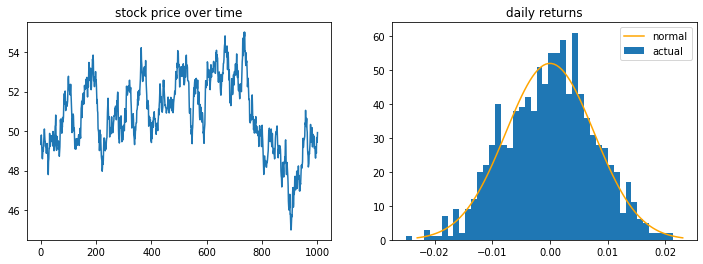

In [89]:
plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
plt.plot(clearing_prices)
plt.plot(cluster_buy, color='green')
plt.plot(cluster_sell, color='red')
plt.title('stock price over time')
plt.subplot(1,2,2)
plt.hist(log_returns, bins=45)
mu, sigma = np.mean(log_returns), np.std(log_returns)
x = np.linspace(mu - 3 * sigma, mu + 3 * sigma, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma), color='orange')
plt.legend(['normal','actual'])
plt.title('daily returns')
plt.show()